In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [2]:
df = pd.read_csv('dataset_SCL.csv',dtype={'Vlo-I': str,'Vlo-O':str})
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


### Data Exploration

2. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

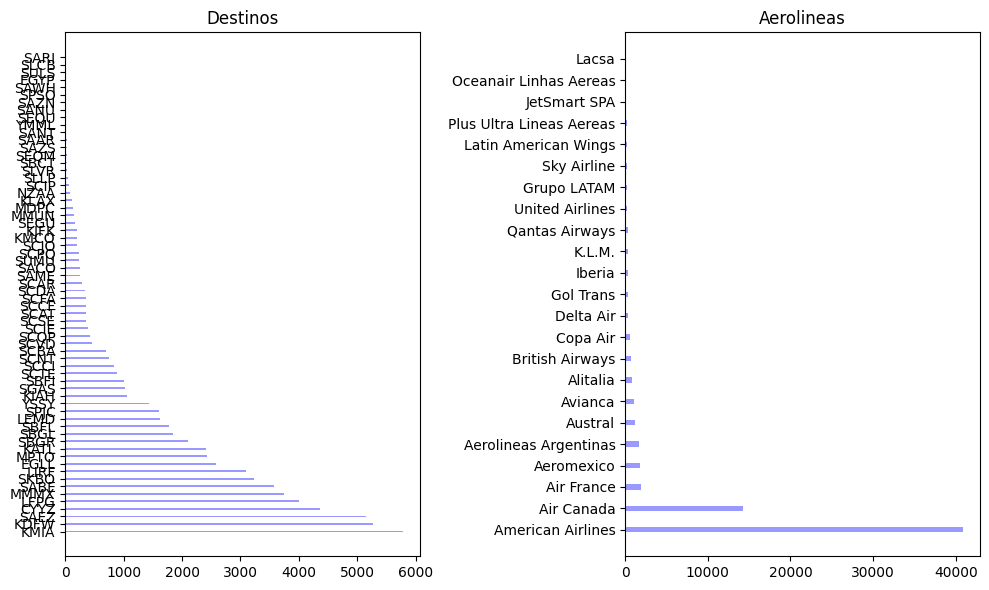

In [3]:
#distribución de los destinos
fig, ax = plt.subplots(1,2,figsize=(10,6))

ax[0].barh(df['Des-I'].unique(), df['Des-I'].value_counts(), 0.25,
                 alpha=0.4,
                 color='b')
ax[0].set_title('Destinos')
ax[1].barh(df['OPERA'].unique(), df['OPERA'].value_counts(), 0.25,
                 alpha=0.4,
                 color='b',
                 label='Destino')
ax[1].set_title('Aerolineas')
plt.tight_layout()
plt.show()

Se puede apreciar que tanto para la categoria Destinos como para Aerolineas hay muchas clases con pequeña cantidad de vuelos, esto puede afectar al momento de predecir, sería interesante buscar categorias para agrupar estos destinos y aerolineas con poca cantidad de vuelos.

Explorando Mes, Semana y Día

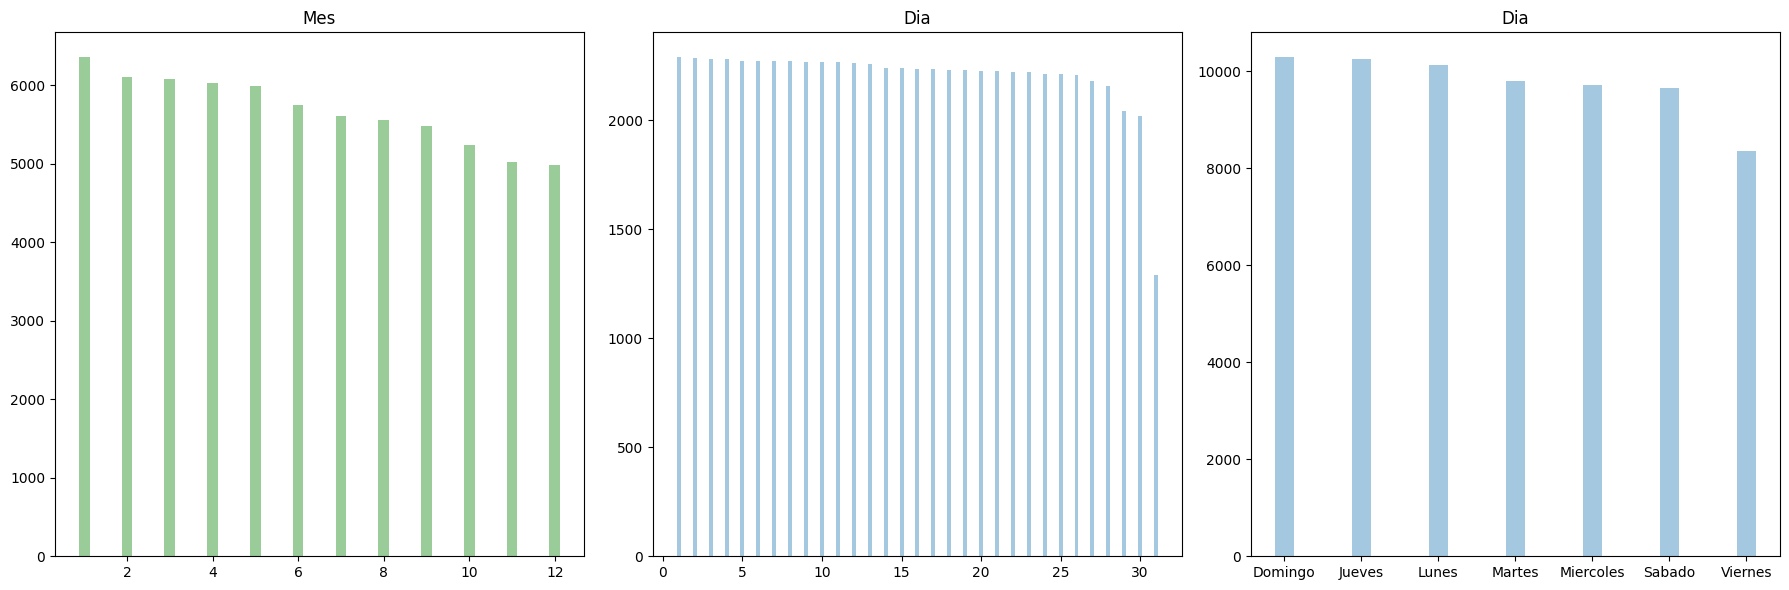

In [4]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
mes_labels= df['MES'].value_counts().index.sort_values()
mes_count = df['MES'].value_counts().values
ax[0].bar(mes_labels,mes_count, 0.25,
                 alpha=0.4,
                 color='g'
                 )
ax[0].set_title('Mes')
dia_labels= df['DIA'].value_counts().index.sort_values()
dia_count = df['DIA'].value_counts().values
ax[1].bar(dia_labels,dia_count, 0.25,
                 alpha=0.4,
                #  color='b'
                 )
ax[1].set_title('Dia')

semana_labels= df['DIANOM'].value_counts().index.sort_values()
semana_count = df['DIANOM'].value_counts().values
ax[2].bar(semana_labels,semana_count, 0.25,
                 alpha=0.4,
                #  color='b'
                 )
ax[2].set_title('Dia')

        

plt.tight_layout()
plt.show()


Las clases dentro de las categorias Mes, Dia y Semana se aprecian bastante balanceadas, esto pudo haber sido por un balanceo previo o de forma natural, esta distribución parece adecuada para evitar predicciones erroneas por desbalance.

### Data Pre-Processing

2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :
- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
- dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
- atraso_15 : 1 si dif_min > 15, 0 si no.
- periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a
Fecha-I .


In [5]:
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])



def temporada_alta(date):
    if datetime.datetime(2017, 12, 15)<=date <=datetime.datetime(2017, 3, 3) or datetime.datetime(2017, 7, 15)<=date <=datetime.datetime(2017, 7, 31) or datetime.datetime(2017, 9, 11)<=date <=datetime.datetime(2017, 9, 30):
        return 1
    else: return 0
def periodo_dia(time):
    if datetime.time(5,0)<=time.time()<= datetime.time(11,59):
        return 'mañana'
    elif datetime.time(12,0)<=time.time()<= datetime.time(18,59):
        return 'tarde'
    else:
        return 'noche'

df['temporada_alta'] = df['Fecha-I'].map(temporada_alta)
df['diff_min'] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds() / 60.0
df['atraso_15'] =  [1 if atraso >15 else 0 for atraso in df['diff_min']]
df['periodo_dia'] = df['Fecha-I'].map(periodo_dia)
syntethic_features = df[['temporada_alta','diff_min','atraso_15','periodo_dia']]
syntethic_features.to_csv('syntethic_features.csv')

#### 3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?


Text(0.5, 1.0, 'Aerolinea')

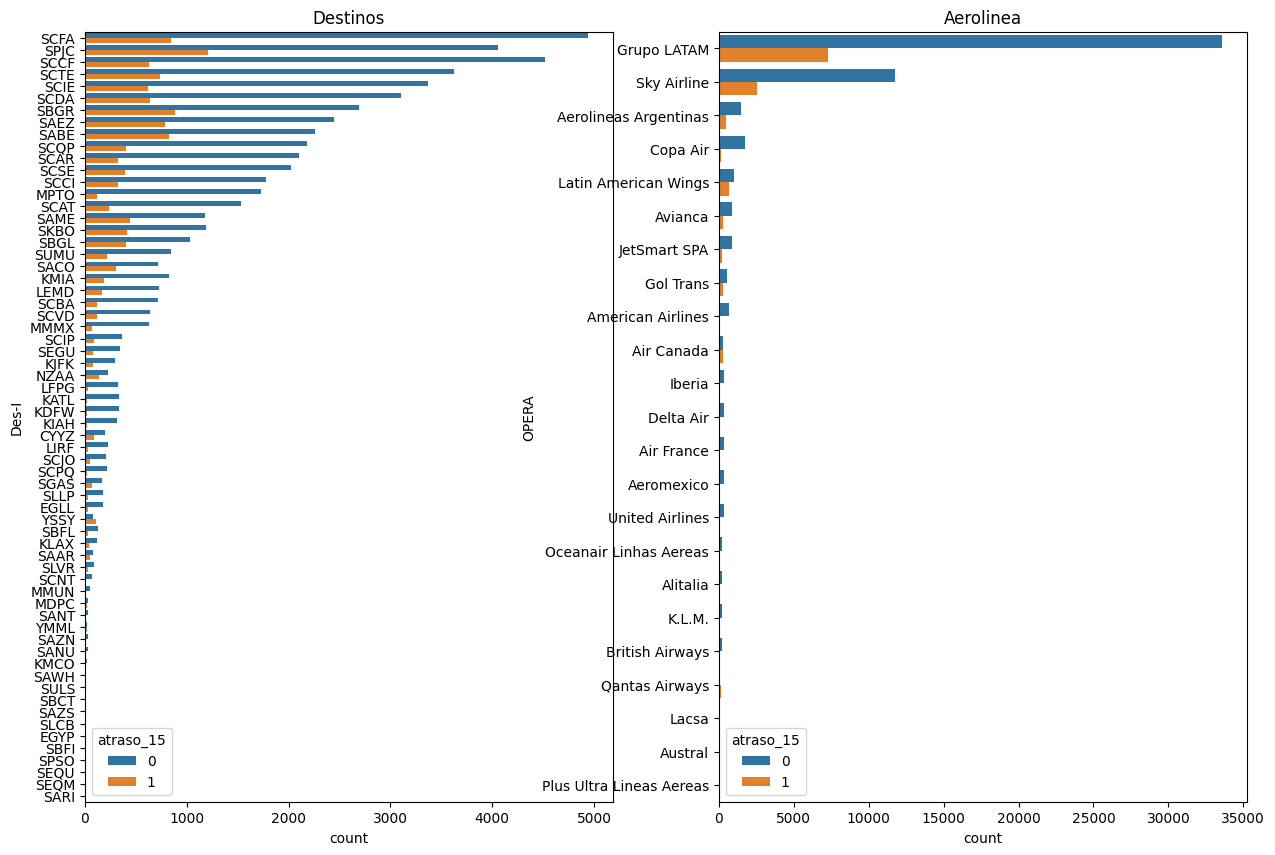

In [6]:
fig,ax = plt.subplots(1,2, figsize=(15,10))
sns.countplot(ax=ax[0],y="Des-I", hue='atraso_15', data=df,order = df['Des-I'].value_counts().index)
sns.countplot(ax=ax[1],y="OPERA", hue='atraso_15', data=df,order = df['OPERA'].value_counts().index)

ax[0].set_title('Destinos')
ax[1].set_title('Aerolinea')
#sns.countplot(ax=ax[2],y="TIPOVUELO", hue='atraso_15', data=df)

Text(0.5, 1.0, 'Temporada Si/No')

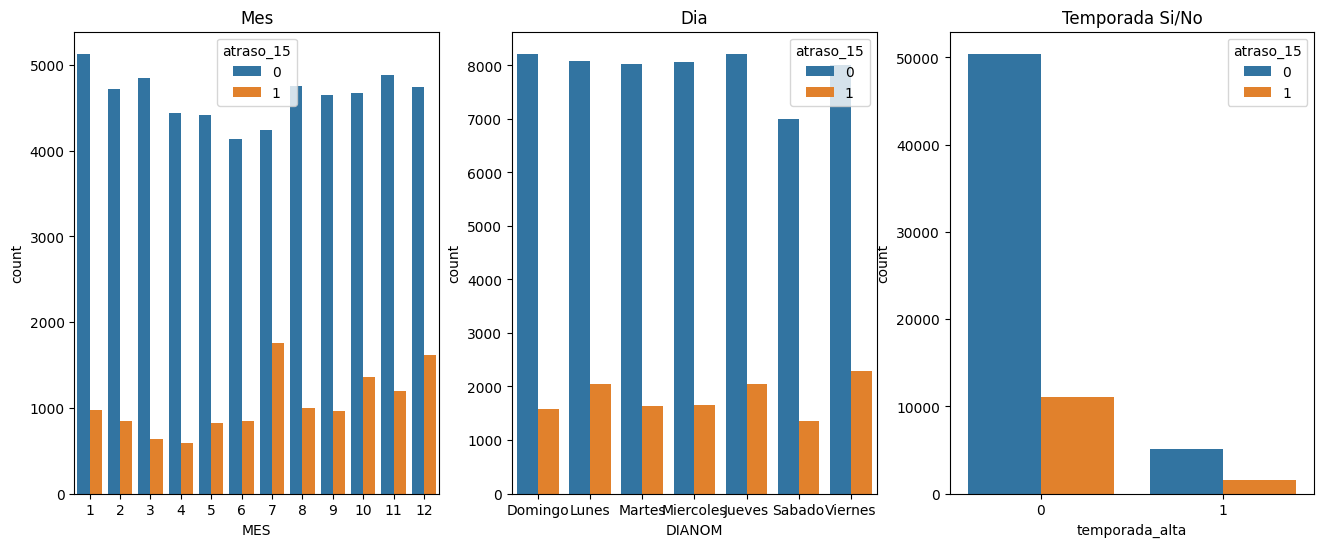

In [7]:

fig,ax = plt.subplots(1,3, figsize=(16,6))
sns.countplot(ax=ax[0],x="MES", hue='atraso_15', data=df)
sns.countplot(ax=ax[1],x="DIANOM", hue='atraso_15', data=df)
sns.countplot(ax=ax[2],x="temporada_alta", hue='atraso_15', data=df)

ax[0].set_title('Mes')
ax[1].set_title('Dia')
ax[2].set_title('Temporada Si/No')

La mayor conclusion de esta exploración es que se puede apreciar un claro desbalance entre la categoria de vuelos atrasados con la vuelos no atrasados, si no se trabaja esto el modelo optara por clasificar siempre que no habrá atrasos.

### Training

#### 4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.

Primero, quitaré las columnas que no utilizaré para el entrenamiento y luego transformaré todas las columnas categoricas para que el modelo pueda procesarlas

In [8]:

dropcols = [
    'Fecha-O', 'Vlo-O','Fecha-I',
       'Ori-O', 'Des-O', 'Emp-O','SIGLAORI','diff_min','Ori-I'
]  # The features are dropped to reduce overfitting

df.dropna(inplace=True)

df['Vlo-I'] = LabelEncoder().fit_transform(df['Vlo-I'])
df['Des-I'] = LabelEncoder().fit_transform(df['Des-I'])
df['Emp-I'] = LabelEncoder().fit_transform(df['Emp-I'])
df['SIGLAORI'] = LabelEncoder().fit_transform(df['SIGLAORI'])
df['DIANOM'] = LabelEncoder().fit_transform(df['DIANOM'])
df['OPERA'] = LabelEncoder().fit_transform(df['OPERA'])
df['SIGLADES'] = LabelEncoder().fit_transform(df['SIGLADES'])
df['periodo_dia'] = LabelEncoder().fit_transform(df['periodo_dia'])
df['TIPOVUELO'] = LabelEncoder().fit_transform(df['TIPOVUELO'])


df_train = df.drop(dropcols,axis=1)
X = df_train.drop('atraso_15',axis=1)
y= df_train.atraso_15


Considerando que la mayoria de los datos son como 'No Atraso' es importante realizar algun procesamiento para manejar la data desbalanceada, en este caso decidí por realizar un RandomUnderSampler, reduciendo la clase mayoritaria, al tener menos datos para entrenar se reducirá el Accuracy del modelo, pero es un costo necesario dado el problema.

In [9]:

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=42)

Decidí Trabajar con un Lightgbm considerando que no tuve mucho tiempo para provar diversos modelos y en mi experiencia LBGM entrega excelente resultados para estos casos

In [10]:


categoricals = [
        "Vlo-I",
        "Des-I",
        "Emp-I",
        "DIANOM",
        'TIPOVUELO',
        'OPERA',
        'SIGLADES',
        'temporada_alta',
        'periodo_dia'

    ]  # These features will be set as categorical features by LightGBM and handled differently

categoricals = [c for c in categoricals if c in X_train.columns]

booster = lgb.LGBMClassifier()    

booster.fit(
        X_train,
        y_train,
        eval_metric=["auc"],
        verbose=100,
        categorical_feature=categoricals)



c:\Users\simon\OneDrive\Documentos\Proyectos\Anaconda3\envs\challenge\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\simon\OneDrive\Documentos\Proyectos\Anaconda3\envs\challenge\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier()

### Evaluation and Conclusion

#### 5.Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la performance?

In [11]:
y_pred=booster.predict(X_test)

print("LightGBM accuracy score: {0:0.4f}".format(accuracy_score(y_test, y_pred)))

LightGBM accuracy score: 0.6498


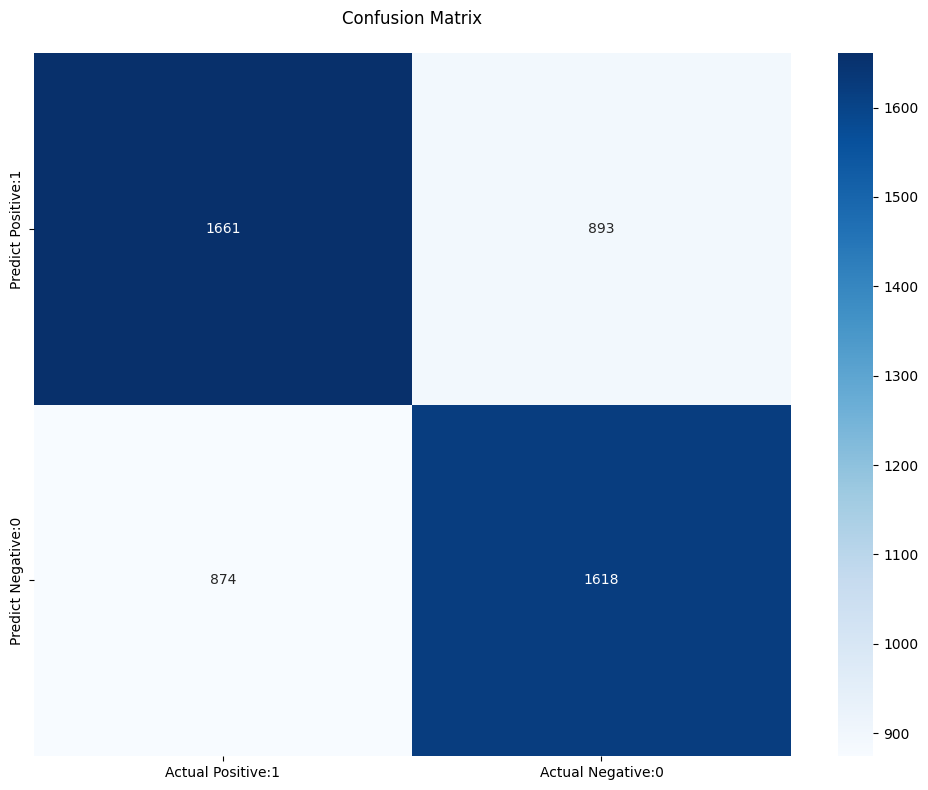

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

Como se puede ver este modelo tiene un accuracy de 65%, Accuracy es una medida bien estandar para comparar diversos modelos, en este caso el resultado es bastante bajo, pero como la clasificación de Atrasos es bastante desbalanceada es importante considerar Precison y Recall, dentro de la Confusion Matrix, se puede apreciar que las predicciones del modelo son bastante parejas entre predicciones positivas y predicciones negativas.

In [13]:
lr= LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)

pd.DataFrame(zip(X_train.columns, np.transpose(lr.coef_.tolist()[0])), columns=['features', 'coef'])

,features,coef
0,Vlo-I,0.000407
1,Des-I,0.004346
2,Emp-I,0.007628
3,DIA,-0.001272
4,MES,0.060824
5,AÑO,-0.000439
6,DIANOM,0.022495
7,TIPOVUELO,-0.528807
8,OPERA,0.007251
9,SIGLADES,0.000206


Aqui podemos apreciar que las variables con mayor influencia son "temporada_alta" y "periodo_dia" lo cual es bastante interesante ya que ambas son variables construidas a partir de otras columnas, ambas relacionadas con el tiempo y donde es necesario un pequeño conocimiento del negocio, de seguro con mas tiempo podriamos construir otras variables que permitan aumentar el performance del modelo, otras categorias que pueden exisir en el periodo del dia o relaciones entre el destino y la fecha.